In [1]:
import cloudknot as ck

In [2]:
def pdd_evaluate(inputs):
    
    def unit_vector(vector):
        return vector / np.linalg.norm(vector, axis=-1)[:, None]

    def angle_between(v1, v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return np.rad2deg(np.arccos(np.clip(np.sum(v1_u * v2_u, axis=-1), -1.0, 1.0)))

    experiment, subject, sigma = inputs
    import os.path as op
    from glob import glob
    import boto3
    import numpy as np
    from AFQ import registration as reg
    import nibabel as nib
    from subprocess import call
    print("Subject ID: %s"%subject)
    
    client = boto3.resource('s3')
    bucket_name1 = 'arokem.mri2mri'
    b1 = client.Bucket(bucket_name1)
    ll1 = list(b1.objects.all())
    bucket_name2 = 'arokem.mri2mri.dwi-predictions'
    b2 = client.Bucket(bucket_name2)
    ll2 = list(b2.objects.all())

    print("Checking if outputs exist")
    exists = 0    
    path = op.join(experiment, 
                   "test_latest", 
                   "gaussian_%s"%sigma)
    
    if op.join(path, "%s_error_template.nii.gz"%subject) in ll2:
        exists = exists + 1
    if op.join(path, "%s_error_nn.nii.gz"%subject) in ll2:
        exists = exists + 1
    
    if exists == 2: 
        b2.download_file(op.join(path, "%s_error_template.nii.gz"%subject), 
                        'error_template.nii.gz')
        b2.download_file(op.join(path, "%s_error_nn.nii.gz"%subject), 
                        'error_nn.nii.gz')
        return nib.load("error_nn.nii.gz").get_data(), nib.load("error_template.nii.gz").get_data() 

    
    print("Downloading IIT template data")
    b1.download_file("IIT-templates/IITmean_V1.nii.gz", "IITmean_V1.nii.gz")
    b1.download_file("IIT-templates/IITmean_t1.nii.gz", "IITmean_t1.nii.gz")

    print("Downloading T1 and DTI data")
    for l in ll1:
        k = l.key
        if k.startswith("IXI-T1" ) and k.split('/')[-1].startswith(subject):
            print("Downloading %s as T1"%k)
            b1.download_file(k, "T1.nii.gz")
        if k.startswith("IXI-data/DTI") and k.split('/')[-1].startswith(subject) and k.endswith("DTI-00.nii.gz"):
            print("Downloading %s as DTI"%k)
            b1.download_file(k, "DTI-00.nii.gz")

    print("Downloading NPY files")
    for l in ll2: 
        k = l.key
        if k.startswith(op.join(path, "numpy")) and op.split(k)[-1].startswith(subject):
            print("Downloading %s"%k)
            b2.download_file(k, op.split(k)[-1])
    
    real_a_files = glob('%s*real_A*.npy'%subject)
    real_b_files = glob('%s*real_B*.npy'%subject)
    fake_b_files = glob('%s*fake_B*.npy'%subject)
    
    real_a_files.sort()
    real_b_files.sort()
    fake_b_files.sort()
    
    real_a = np.zeros((len(real_a_files), 128, 128, 3))
    real_b = np.zeros((len(real_a_files), 128, 128, 3))
    fake_b = np.zeros((len(real_a_files), 128, 128, 3))
    for ii in range(len(real_a_files)):
        real_a[ii]= np.load(real_a_files[ii]) 
        real_b[ii]= np.load(real_b_files[ii]) 
        fake_b[ii]= np.load(fake_b_files[ii])    

    meanV1_img = nib.load('IITmean_V1.nii.gz')
    meant1_img = nib.load('IITmean_t1.nii.gz')

    meanV1 = meanV1_img.get_data()
    meant1 = meant1_img.get_data()

    b1.download_file("IXI_template/T_template3.nii.gz", "T_template3.nii.gz")
    b1.download_file("IXI_template/T_template_BrainCerebellumProbabilityMask.nii.gz", 
                    "T_template_BrainCerebellumProbabilityMask.nii.gz")


    skull_stripped_t1 = op.join('dwi-predictions',
                                'skullstripped',
                                '%s_skullstripped_t1.nii.gz'%subject) 
    
    has_skull_stripped = False
    for l in ll2:
        k = l.key
        if skull_stripped_t1 == k:
            print("Downloading %s as skull-stripped"%skull_stripped_t1)
            b2.download_file(k, 'T1_BrainExtractionBrain.nii.gz')
            has_skull_stripped = True

    if not has_skull_stripped:
        print("Running ANTS for skull stripping")
        ants_call = ["antsBrainExtraction.sh", 
                     "-d", "3", "-a", "T1.nii.gz",
                     "-e" "T_template3.nii.gz", 
                     "-m", "T_template_BrainCerebellumProbabilityMask.nii.gz",
                     "-o", "T1_"]

        call(ants_call)            
        b2.upload_file('T1_BrainExtractionBrain.nii.gz', 
                       skull_stripped_t1)

    ants_brain_img = nib.load('T1_BrainExtractionBrain.nii.gz')
    ants_brain = ants_brain_img.get_data()
    print("Affine registration")
    transformed, affine = reg.affine_registration(meant1, ants_brain, meant1_img.affine, ants_brain_img.affine)   
    print("SyN registration")
    warped_meant1, mapping = reg.syn_registration(meant1, ants_brain, moving_affine=meant1_img.affine, static_affine=ants_brain_img.affine, prealign=affine)                  
    
    print("Applying transformations")

    mapped = np.concatenate([mapping.transform(meanV1[..., 0])[..., np.newaxis], 
                             mapping.transform(meanV1[..., 1])[..., np.newaxis], 
                             mapping.transform(meanV1[..., 2])[..., np.newaxis]], -1) 

    DWI_img = nib.load('DTI-00.nii.gz')
    DWI_affine = DWI_img.affine
    resamp = np.concatenate([reg.resample(mapped[..., 0], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                             reg.resample(mapped[..., 1], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis], 
                             reg.resample(mapped[..., 2], DWI_img.get_data(), ants_brain_img.affine, DWI_affine)[..., np.newaxis]], -1)[:,:,1:-1]
                         
    resamp = np.moveaxis(resamp, 2, 0)

    b1.download_file(op.join('IXI-Freesurfer-segmentations', subject, "mri", "aparc+aseg.mgz"), 
                           "segmentation.mgz")
    mask_img = nib.load('segmentation.mgz')
    mask_data = mask_img.get_data()
    mask = (mask_data == 2) | (mask_data == 41)
    
    mask_resamp = reg.resample(mask.astype(float),
                               DWI_img.get_data(), 
                               mask_img.affine, 
                               DWI_affine)[:,:,1:-1]

    mask_resamp = np.moveaxis(mask_resamp, 2, 0)
    mask = mask_resamp.astype(bool)
    
    print("Calculating fake error")
    angle_fake = angle_between(real_b[mask], fake_b[mask])
    angle_fake = np.min([angle_fake, 180-angle_fake], 0)

    vol = np.nan * np.ones(real_b.shape[:3])
    vol[mask] = angle_fake
    
    nib.save(nib.Nifti1Image(vol, DWI_affine), '%s_error_nn.nii.gz'%subject)
    print("Uploading fake error")
    b2.upload_file('%s_error_nn.nii.gz'%subject, 
                   op.join(path, 'errors', "%s_error_nn.nii.gz"%subject)) 
    
    print("Calculating template error")
    angle_template = angle_between(real_b[mask], resamp[mask])
    angle_template = np.min([angle_template, 180-angle_template], 0)

    vol = np.nan * np.ones(real_b.shape[:3])
    vol[mask] = angle_template

    nib.save(nib.Nifti1Image(vol, DWI_affine), '%s_error_template.nii.gz'%subject)
    print("Uploading template error")
    b2.upload_file('%s_error_template.nii.gz'%subject, 
                   op.join(path, 'errors', "%s_error_template.nii.gz"%subject)) 
    
    print("Returning outputs")
    return angle_fake, angle_template

In [3]:
image = ck.DockerImage(func=pdd_evaluate, 
                       github_installs=("git://github.com/arokem/pyAFQ.git@no_pathlib"),
                       base_image="arokem/ants:16")

In [4]:
knot = ck.Knot(name='ants-pdd-evaluate16_38',
               docker_image=image,
               memory=12000,
               bid_percentage=100,
               resource_type="SPOT",
               pars_policies=('AmazonS3FullAccess',))

In [5]:
from glob import glob

In [6]:
ids = list(set([foo.split('/')[-1].split('-')[0] for 
                foo in glob('/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/*')]))

In [7]:
ids.remove("volumes")

In [8]:
experiment = "t1_pdd_cosine_L1_unet128_T3_3d"
sigma = "0.1"

In [9]:
inputs = [(experiment, subject, sigma) for subject in ids]

In [10]:
inputs[0]

('t1_pdd_cosine_L1_unet128_T3_3d', 'IXI468', '0')

In [11]:
result_futures = knot.map(inputs)

In [21]:
# knot.clobber()

In [13]:
j0 = knot.jobs[0]

In [19]:
j0.status

{'arrayProperties': {u'size': 77,
  u'statusSummary': {u'FAILED': 0,
   u'PENDING': 0,
   u'RUNNABLE': 0,
   u'RUNNING': 0,
   u'STARTING': 0,
   u'SUBMITTED': 0,
   u'SUCCEEDED': 77}},
 'attempts': [],
 'status': u'SUCCEEDED',
 'statusReason': None}

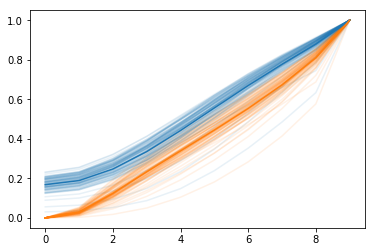

In [146]:
# results = results_0
# fig, ax = plt.subplots(1)
# p0 = np.zeros((len(results), th_arr.shape[0]))
# p1 = np.zeros((len(results), th_arr.shape[0]))
# comparison0 = np.zeros((2, len(results)))
# th_arr = np.arange(0, 100, 10)

# for jj, r in enumerate(results):
#     for ii, th in enumerate(th_arr):
#         p0[jj, ii] = np.sum(r[0] <= th) / float(len(r[0]))
#         p1[jj, ii] = np.sum(r[1] <= th) / float(len(r[1]))

#     ax.plot(p0[jj], color='#1f77b4', alpha=0.1)
#     ax.plot(p1[jj], color='#ff7f0e', alpha=0.1)
#     comparison0[0, jj] = np.sum(p0[jj]) / len(th_arr)
#     comparison0[1, jj] = np.sum(p1[jj]) / len(th_arr)
    
# ax.plot(np.mean(p0, 0), color='#1f77b4')
# ax.plot(np.mean(p1, 0), color='#ff7f0e')

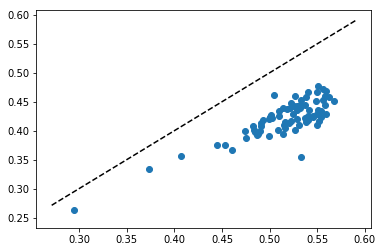

In [159]:
# fig, ax = plt.subplots(1)
# ax.scatter(comparison0[0], comparison0[1])
# ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_xlim()[0], ax.get_xlim()[1]], 'k--')

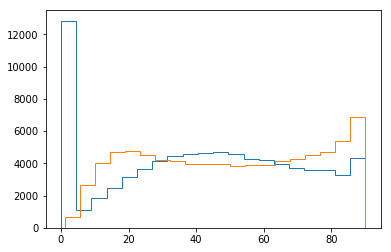

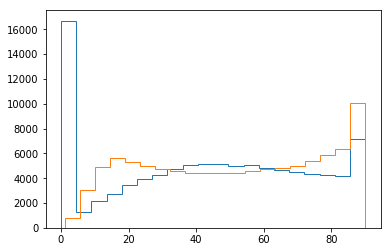

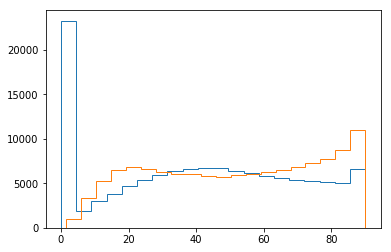

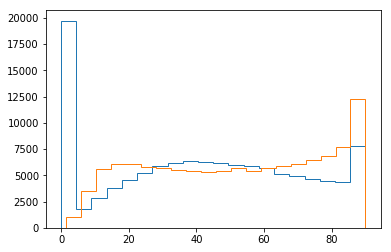

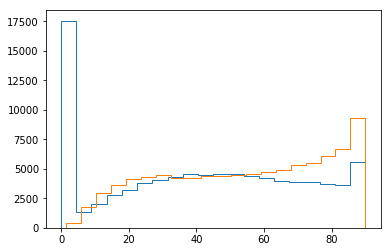

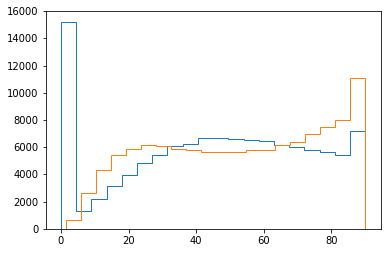

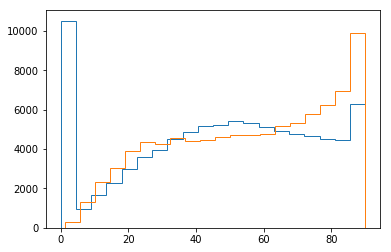

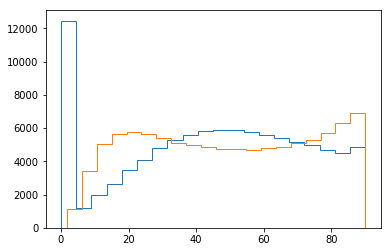

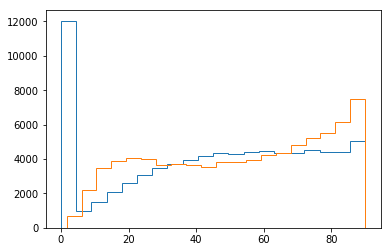

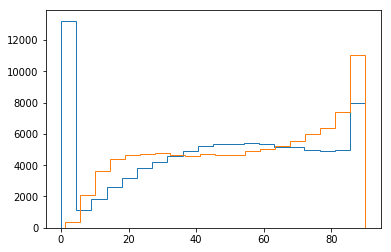

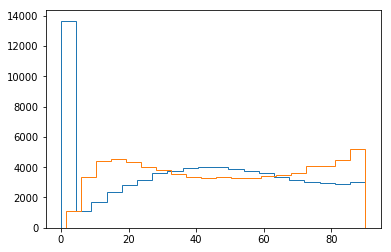

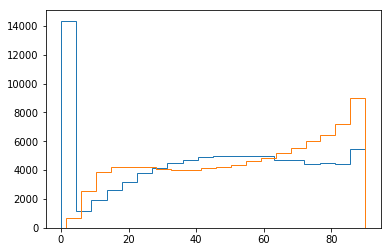

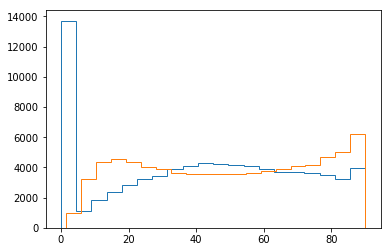

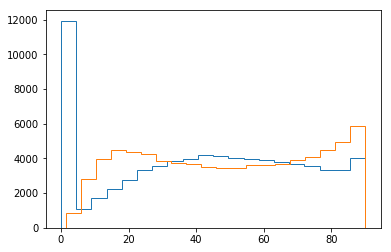

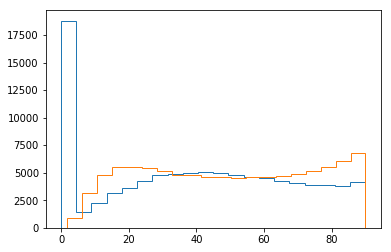

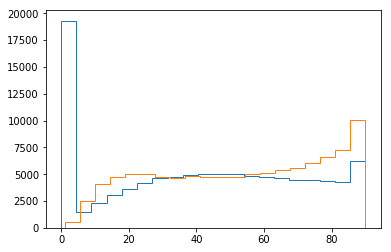

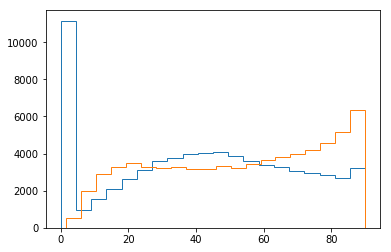

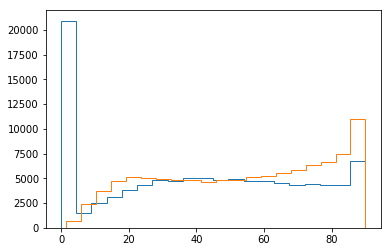

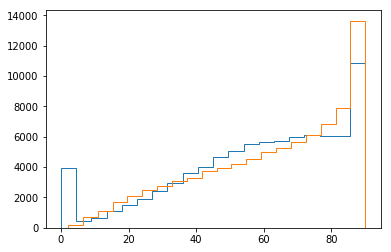

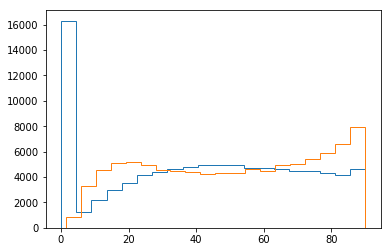

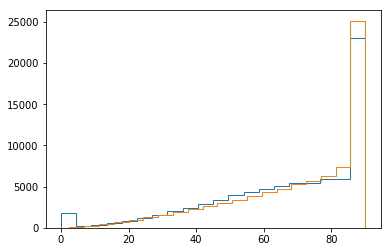

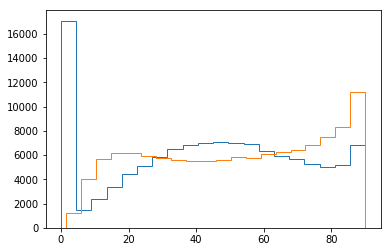

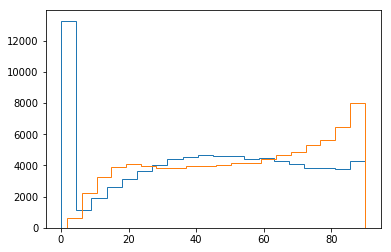

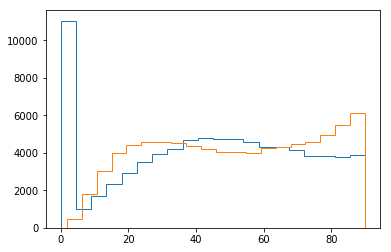

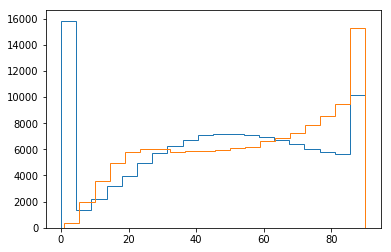

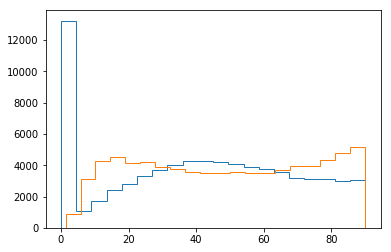

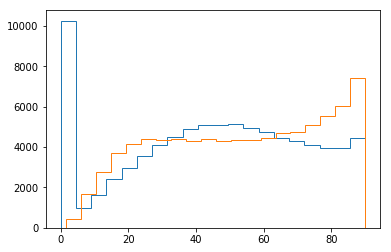

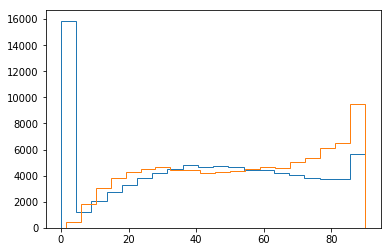

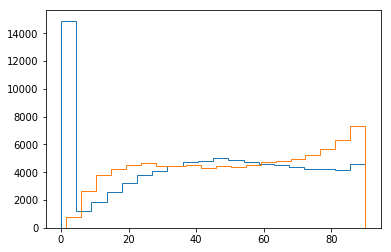

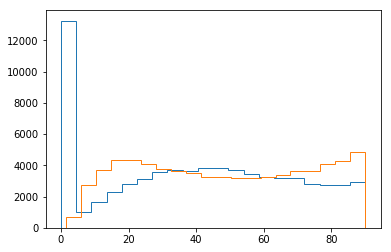

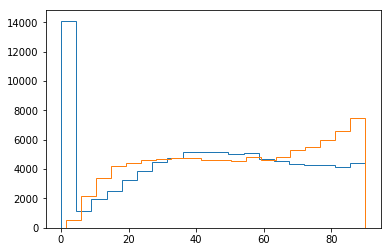

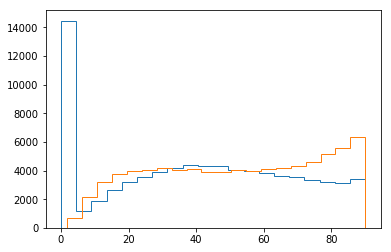

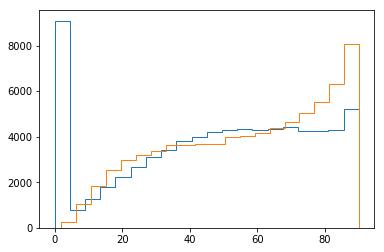

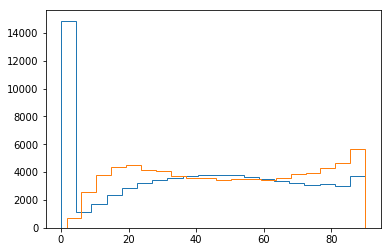

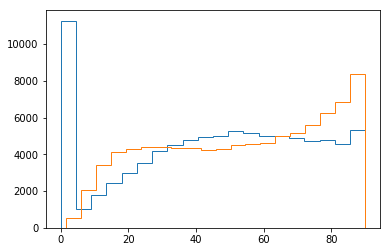

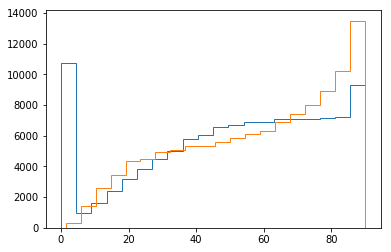

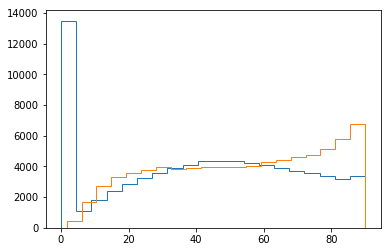

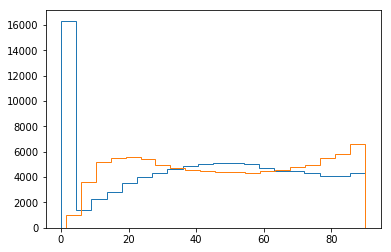

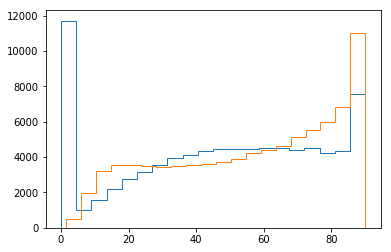

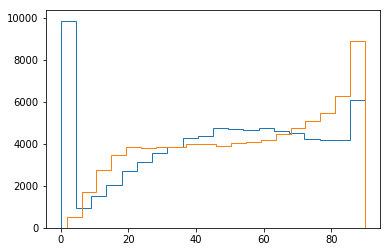

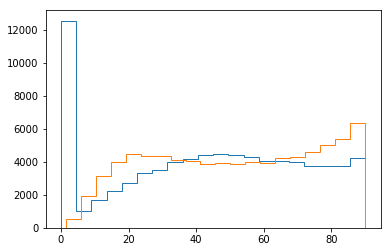

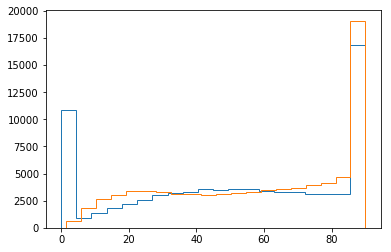

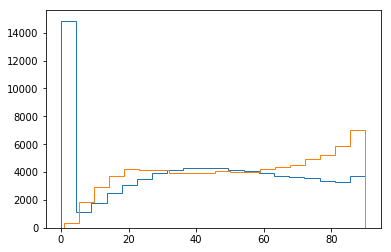

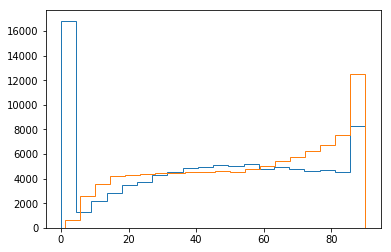

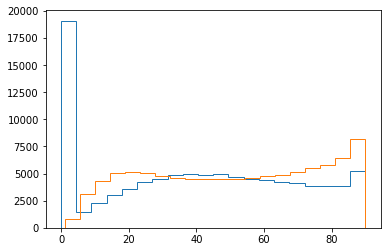

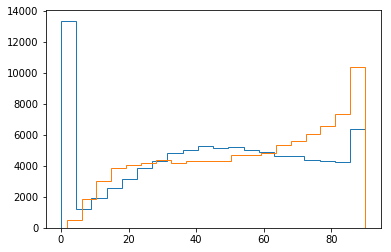

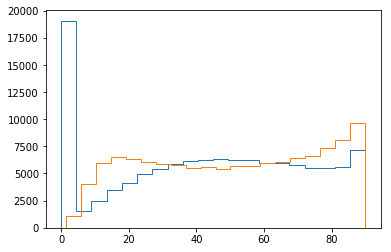

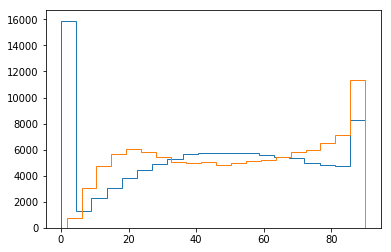

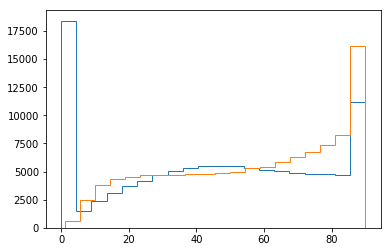

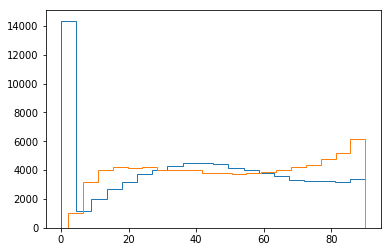

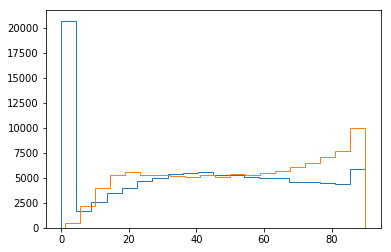

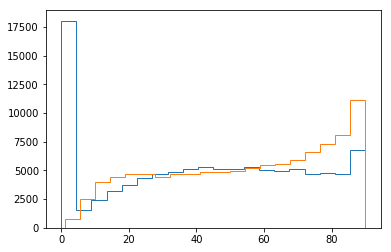

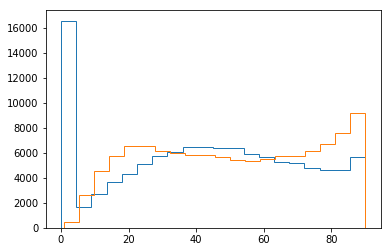

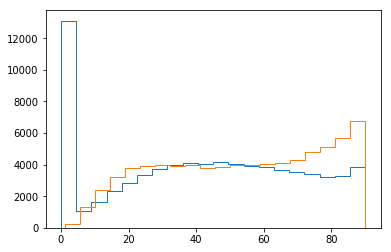

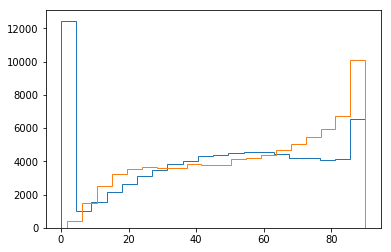

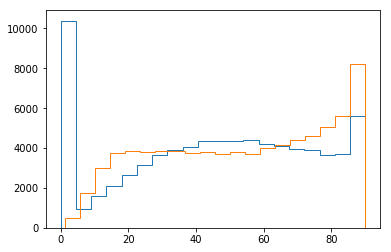

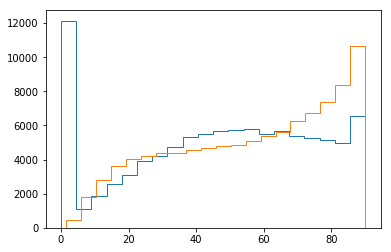

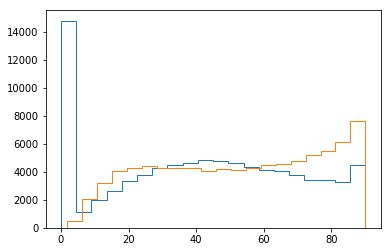

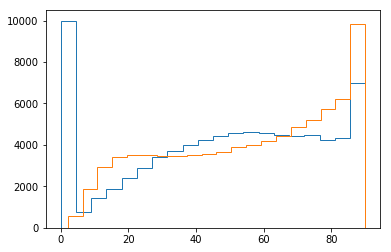

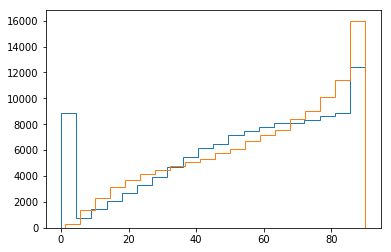

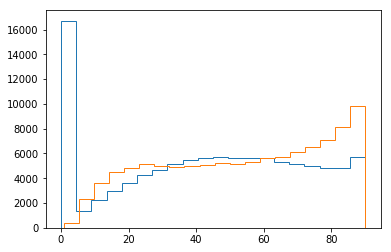

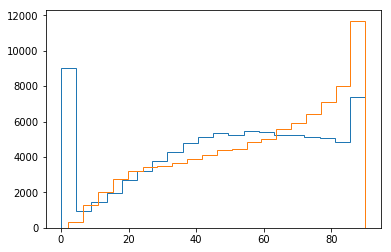

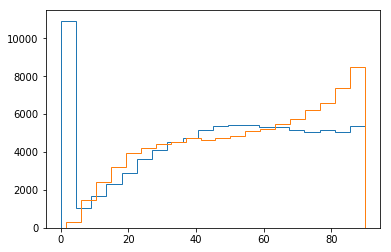

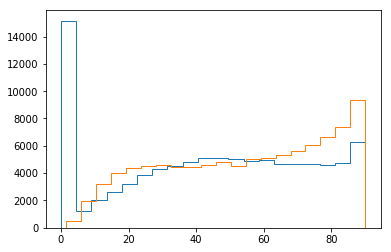

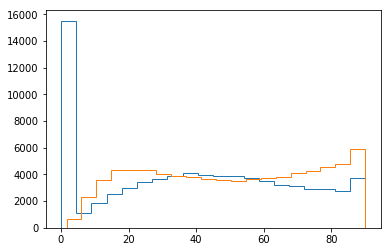

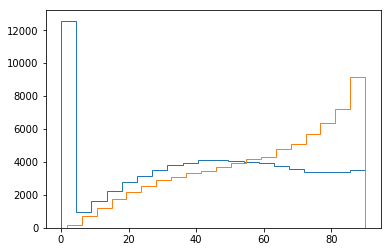

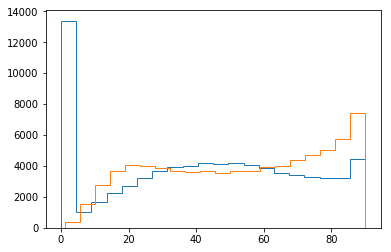

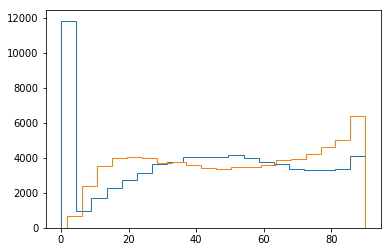

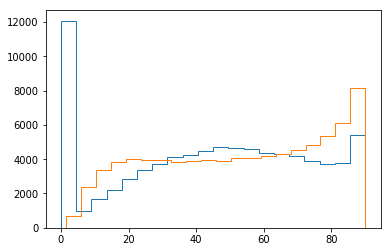

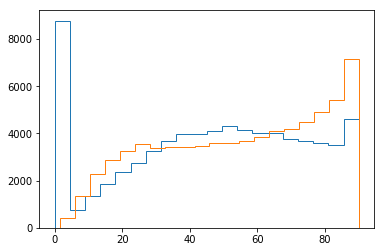

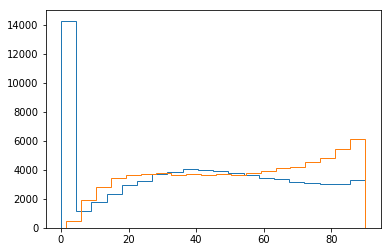

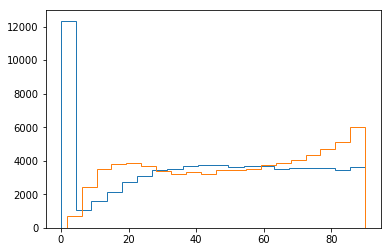

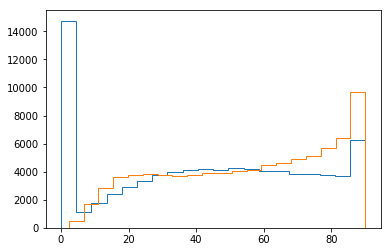

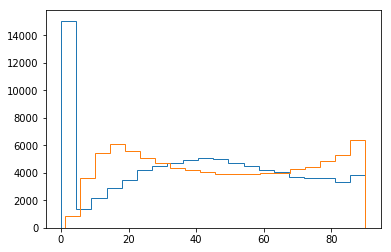

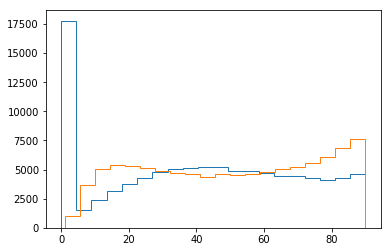

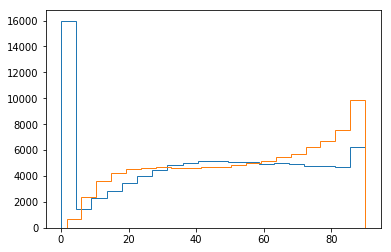

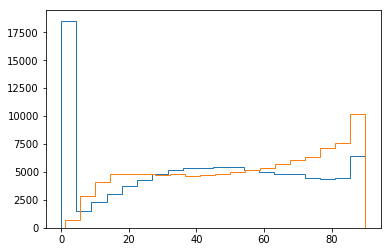

In [55]:
# for r in results:
#     fig, ax = plt.subplots(1)
#     ax.hist(r[0], bins=20, histtype='step')
#     ax.hist(r[1], bins=20, histtype='step')

In [17]:
# for f in foo:
#     fig, ax = plt.subplots(1)
#     ax.hist(f)

In [18]:
# for sub in ids:
#     real_a_files = []
#     real_b_files = []
#     fake_b_files = []

#     for k in glob('/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/*%s*'%sub):
#         if k.endswith('real_A.npy'):
#             real_a_files.append(k)
#         elif k.endswith('real_B.npy'):
#             real_b_files.append(k)
#         elif k.endswith('fake_B.npy'):
#             fake_b_files.append(k)

#     real_a_files.sort()
#     real_b_files.sort()
#     fake_b_files.sort()
#     real_a = np.zeros((len(real_a_files), 128, 128, 3))
#     real_b = np.zeros((len(real_a_files), 128, 128, 3))
#     fake_b = np.zeros((len(real_a_files), 128, 128, 3))
#     for ii in range(len(real_a_files)):
#         real_a[ii]= np.load(real_a_files[ii]) 
#         real_b[ii]= np.load(real_b_files[ii]) 
#         fake_b[ii]= np.load(fake_b_files[ii])
#     np.save('/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/volumes/%s_real_A.npy'%sub, real_a, allow_pickle=False)
#     np.save('/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/volumes/%s_real_B.npy'%sub, real_b, allow_pickle=False)
#     np.save('/Users/arokem/data/mri2mri/t1_pdd_cosine_L1_unet128_T3_3d/volumes/%s_fake_B.npy'%sub, fake_b, allow_pickle=False)
